# Sistemas de recomendación basados en Grafos con NetworkX



## Agenda

- Introducción al problema
- ¿Qué **ventajas** nos dan los grafos?
- **Construir** el grafo
- Recomendador con **Jaccard**
- Recomendador con **personalized-pagerank**
- Evaluación

## Introducción al problema

Tenemos a nuestra disposición un listado con todas las compras de sus clientes, incluyendo:
- Cliente (comprador)
- Producto que ha comprado
- Fecha de la compra

Nuestra tarea es, para cada cliente, ofrecer un listado de productos que creemos que puedan ser de interés.

## ¿Qué ventajas nos dan los grafos?

- Los grafos nos van a permitir diseñar un modelo que se adapta muy fácilmente a los datos que tenemos disponibles, en el que las relaciones van a tener tanta importancia como las entidades.
- Las recomendaciones se van a convertir en una tarea muy típica en grafos: predicción de aristas.
- Los grafos aportan contexto multirrelacional y transparencia en los recorridos.

## Construir el grafo

### Modelo

- Nodos: **Usuarios** y **Productos**
- Aristas: **compras** (Usuario-Producto, incluyen la fecha de adquisición)

Cargamos el fichero con las compras, `transactions.csv`.

In [20]:
import polars as pl
import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt

DATA_PATH = Path("transactions.csv")

interactions_df = pl.read_csv(DATA_PATH, try_parse_dates=True).sort("timestamp")
interactions_df.head()


user,product,timestamp
str,str,datetime[μs]
"""u13""","""i039""",2024-01-01 09:18:00
"""u12""","""i094""",2024-01-02 16:59:00
"""u23""","""i067""",2024-01-02 21:55:00
"""u24""","""i071""",2024-01-03 09:46:00
"""u09""","""i037""",2024-01-04 10:49:00


In [21]:
# Resumen del dataset

summary = {
    "users": interactions_df["user"].n_unique(),
    "products": interactions_df["product"].n_unique(),
    "interactions": interactions_df.height,
}
summary


{'users': 30, 'products': 99, 'interactions': 374}

## Construir el grafo

### Modelo


Convertimos la tabla en un grafo bipartito donde usuarios y productos viven en particiones separadas.

In [22]:
def build_bipartite_graph(df: pl.DataFrame) -> nx.Graph:
    """Crear el grafo de compras"""
    B = nx.Graph()
    users = df["user"].unique().to_list()
    products = df["product"].unique().to_list()
    B.add_nodes_from(users, bipartite="users")
    B.add_nodes_from(products, bipartite="products")
    for row in df.iter_rows(named=True):
        B.add_edge(row["user"], row["product"], timestamp=row["timestamp"])
    return B


B_full = build_bipartite_graph(interactions_df)
print(f"Nodes: {B_full.number_of_nodes()} | Edges: {B_full.number_of_edges()}")
user_nodes = [n for n, data in B_full.nodes(data=True) if data["bipartite"] == "users"]
product_nodes = [
    n for n, data in B_full.nodes(data=True) if data["bipartite"] == "products"
]
print(f"User nodes: {len(user_nodes)} | Product nodes: {len(product_nodes)}")


Nodes: 129 | Edges: 374
User nodes: 30 | Product nodes: 99


Confirmamos que el tipo de los nodos se ha cargado correctamente.

In [23]:
for node in user_nodes[:3]:
    print(node, B_full.nodes[node])
for node in product_nodes[:3]:
    print(node, B_full.nodes[node])


u08 {'bipartite': 'users'}
u27 {'bipartite': 'users'}
u28 {'bipartite': 'users'}
i083 {'bipartite': 'products'}
i020 {'bipartite': 'products'}
i003 {'bipartite': 'products'}


Visualizamos a continuación un egografo centrado en un usuario concreto

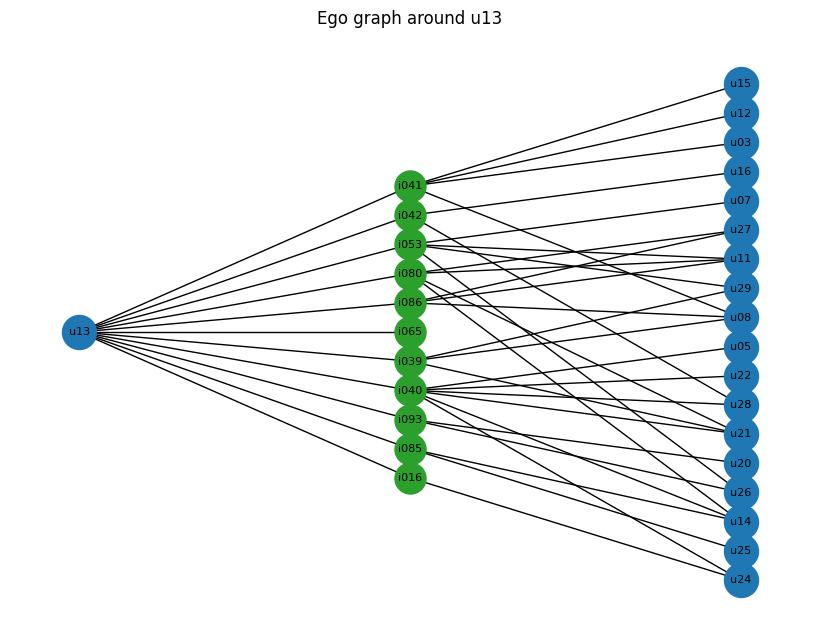

In [24]:
def plot_ego(B: nx.Graph, user: str) -> None:
    """Generar una visualización del egografo centrado en un usuario"""
    if user not in B:
        raise ValueError(f"User {user} not present in the graph")

    ego: nx.Graph = nx.ego_graph(B, user, radius=2)
    # pos = nx.spring_layout(ego, seed=7)
    # pos = nx.bipartite_layout(ego, nodes=[n for n in ego.nodes if ego.nodes[n]["bipartite"] == "users"])
    pos = nx.bfs_layout(ego, start=user)
    plt.figure(figsize=(8, 6))
    nx.draw(ego, pos, with_labels=True, node_size=400, font_size=8)
    nx.draw_networkx_nodes(
        ego,
        pos,
        nodelist=[n for n in ego.nodes if ego.nodes[n]["bipartite"] == "users"],
        node_size=600,
        node_color="tab:blue",
    )
    nx.draw_networkx_nodes(
        ego,
        pos,
        nodelist=[n for n in ego.nodes if ego.nodes[n]["bipartite"] == "products"],
        node_size=500,
        node_color="tab:green",
    )
    plt.title(f"Ego graph around {user}")
    plt.show()


example_user = interactions_df["user"][0]
plot_ego(B_full, example_user)


## Evaluación con Jaccard

Comenzamos con un calificador Jaccard nativo de grafos que se apoya en los ayudantes de prediccion de enlaces de NetworkX y lo comparamos con Personalized PageRank.

In [ ]:
from collections import defaultdict


def recommend_jaccard_graph(
    B: nx.Graph,
    user: str,
) -> pl.DataFrame:
    """Usar jaccard_coefficient para puntuar productos para un usuario."""
    if user not in B:
        return pl.DataFrame({"product": [], "score": []})
    ego: nx.Graph = nx.ego_graph(B, user, radius=2, center=False)

    neighbors = [
        n for n, data in ego.nodes(data=True) if data.get("bipartite") == "users"
    ]
    seen = set(B.neighbors(user))
    ebunch = list((user, neighbor) for neighbor in neighbors)
    jaccard = dict([((u, v), p) for u, v, p in nx.jaccard_coefficient(B, ebunch)])
    scored_products = defaultdict(float)

    for neighbor in neighbors:
        for product in B.neighbors(neighbor):
            if product not in seen:
                scored_products[product] += jaccard.get((user, neighbor), 0)

    return pl.DataFrame(
        {
            "product": list(scored_products.keys()),
            "score": list(scored_products.values()),
        }
    )


demo_user = interactions_df["user"][0]
cf_demo = recommend_jaccard_graph(B_full, demo_user)

print(f"Demo user: {demo_user}")
print("Recomendaciones Jaccard:", cf_demo.sort("score", descending=True).head(5))


Demo user: u13
Jaccard suggestions: shape: (5, 2)
┌─────────┬──────────┐
│ product ┆ score    │
│ ---     ┆ ---      │
│ str     ┆ f64      │
╞═════════╪══════════╡
│ i031    ┆ 0.783358 │
│ i059    ┆ 0.448332 │
│ i095    ┆ 0.445279 │
│ i013    ┆ 0.386518 │
│ i004    ┆ 0.352341 │
└─────────┴──────────┘


## Evaluación con Personalized Pagerank

In [ ]:
def recommend_ppr(
    B: nx.Graph, user: str, *, alpha: float = 0.85, max_iter: int = 100
) -> pl.DataFrame:
    """Usar Personalized PageRank para puntuar productos para un usuario."""
    if user not in B:
        return pl.DataFrame({"product": [], "score": []})
    personalization = {user: 1.0}
    scores = nx.pagerank(
        B, alpha=alpha, personalization=personalization, max_iter=max_iter
    )
    seen = set(B.neighbors(user))

    scored_products = {
        node: score
        for node, score in scores.items()
        if B.nodes[node].get("bipartite") == "products" and node not in seen
    }

    return pl.DataFrame(
        {
            "product": list(scored_products.keys()),
            "score": list(scored_products.values()),
        }
    )


demo_user = interactions_df["user"][0]
ppr_demo = recommend_ppr(B_full, demo_user)
print(f"Demo user: {demo_user}")
print("Recomendaciones PPR:", ppr_demo.sort("score", descending=True).head(5))


Demo user: u13
PPR suggestions: shape: (5, 2)
┌─────────┬──────────┐
│ product ┆ score    │
│ ---     ┆ ---      │
│ str     ┆ f64      │
╞═════════╪══════════╡
│ i031    ┆ 0.009069 │
│ i059    ┆ 0.005683 │
│ i076    ┆ 0.00535  │
│ i095    ┆ 0.005149 │
│ i013    ┆ 0.005048 │
└─────────┴──────────┘


## Evaluación

Usamos la última compra para calcular la calidad de las recomendaciones.

In [30]:
def train_test_split_last_product_per_user(
    df: pl.DataFrame,
) -> tuple[pl.DataFrame, pl.DataFrame]:
    """Separar la última compra según el timestamp."""
    df_sorted = df.sort(["user", "timestamp"]).with_row_index("row_id")
    test = df_sorted.group_by("user", maintain_order=True).tail(1)
    train = df_sorted.filter(~pl.col("row_id").is_in(test["row_id"].implode()))
    return train.drop("row_id"), test.drop("row_id")


def precision_recall_at_k(
    recs: list[str], truth: list[str], k: int
) -> tuple[float, float]:
    """Devolver Precision@k y Recall@k para un listado."""
    recs_k = recs[:k]
    hits = len(set(recs_k) & set(truth))
    precision = hits / max(1, len(recs_k))
    recall = hits / max(1, len(truth))
    return precision, recall


def to_user_products(df: pl.DataFrame) -> dict[str, set[str]]:
    """Devuelve un dict con el set de productos que ha comprado cada usuario."""
    user_products: dict[str, set[str]] = defaultdict(set)
    for row in df.iter_rows(named=True):
        user_products[row["user"]].add(row["product"])
    return user_products


def evaluate_jaccard_graph(
    train_df: pl.DataFrame, test_df: pl.DataFrame, *, topn: int
) -> tuple[float, float, int]:
    train_graph = build_bipartite_graph(train_df)
    test_user_products = to_user_products(test_df)
    metrics: list[tuple[float, float]] = []
    for user, truth_products in test_user_products.items():
        if user not in train_graph:
            continue
        scores_df = recommend_jaccard_graph(train_graph, user)
        if scores_df.height == 0:
            continue
        recs = (
            scores_df.sort("score", descending=True)
            .head(topn)
            .get_column("product")
            .to_list()
        )
        precision, recall = precision_recall_at_k(recs, list(truth_products), topn)
        metrics.append((precision, recall))
    if not metrics:
        return 0.0, 0.0, 0
    precision_avg = sum(p for p, _ in metrics) / len(metrics)
    recall_avg = sum(r for _, r in metrics) / len(metrics)
    return precision_avg, recall_avg, len(metrics)


def evaluate_ppr(
    train_df: pl.DataFrame, test_df: pl.DataFrame, *, topn: int
) -> tuple[float, float, int]:
    train_graph = build_bipartite_graph(train_df)
    test_user_products = to_user_products(test_df)
    metrics: list[tuple[float, float]] = []
    for user, truth_products in test_user_products.items():
        if user not in train_graph:
            continue
        scores_df = recommend_ppr(train_graph, user)
        if scores_df.height == 0:
            continue
        recs = (
            scores_df.sort("score", descending=True)
            .head(topn)
            .get_column("product")
            .to_list()
        )
        precision, recall = precision_recall_at_k(recs, list(truth_products), topn)
        metrics.append((precision, recall))
    if not metrics:
        return 0.0, 0.0, 0
    precision_avg = sum(p for p, _ in metrics) / len(metrics)
    recall_avg = sum(r for _, r in metrics) / len(metrics)
    return precision_avg, recall_avg, len(metrics)


In [42]:
train_df, test_df = train_test_split_last_product_per_user(interactions_df)
top_k = 5
cf_prec, cf_rec, cf_users = evaluate_jaccard_graph(train_df, test_df, topn=top_k)
ppr_prec, ppr_rec, ppr_users = evaluate_ppr(train_df, test_df, topn=top_k)
print(
    f"Graph Jaccard Precision@{top_k}: {cf_prec:.3f} | Recall@{top_k}: {cf_rec:.3f} over {cf_users} users"
)
print(
    f"PPR Precision@{top_k}: {ppr_prec:.3f} | Recall@{top_k}: {ppr_rec:.3f} over {ppr_users} users"
)


Graph Jaccard Precision@5: 0.013 | Recall@5: 0.067 over 30 users
PPR Precision@5: 0.013 | Recall@5: 0.067 over 30 users


### Cierre

- El filtrado colaborativo funciona mejor cuando los usuarios comparten interacciones densas.
- Personalized PageRank propaga senales de preferencia a traves del grafo y puede descubrir productos incluso con traslape directo escaso.
- Sustituye pesos de arista mas ricos o informacion contextual para ampliar la leccion.

## Next steps

- Usar un algoritmo tipo graph2vec para crear embeddings, y que estos formen parte de un modelo ML más avanzado.